In [1]:
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0  23372      0 --:--:-- --:--:-- --:--:-- 23775
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


In [0]:
!git clone https://github.com/MichalDanielDobrzanski/DeepLearningPython35

Cloning into 'DeepLearningPython35'...
remote: Enumerating objects: 55, done.
remote: Total 55 (delta 0), reused 0 (delta 0), pack-reused 55
Unpacking objects: 100% (55/55), done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!pip install autograd

  Running setup.py bdist_wheel for autograd ... - \ done
  Stored in directory: /root/.cache/pip/wheels/72/6f/c2/40f130cca2c91f31d354bf72de282922479c09ce0b7853c4c5
Successfully built autograd


In [0]:
import numpy as np
from sklearn import preprocessing
from matplotlib import pyplot as plt
import autograd.numpy as np_autograd
from autograd import elementwise_grad as egrad
import cupy as cp
import pickle
%matplotlib inline

In [0]:
# %load mnist_loader.py
"""
mnist_loader
~~~~~~~~~~~~
A library to load the MNIST image data.  For details of the data
structures that are returned, see the doc strings for ``load_data``
and ``load_data_wrapper``.  In practice, ``load_data_wrapper`` is the
function usually called by our neural network code.
"""

#### Libraries
# Standard library
import pickle
import gzip

# Third-party libraries
import numpy as np

def load_data():
    """Return the MNIST data as a tuple containing the training data,
    the validation data, and the test data.
    The ``training_data`` is returned as a tuple with two entries.
    The first entry contains the actual training images.  This is a
    numpy ndarray with 50,000 entries.  Each entry is, in turn, a
    numpy ndarray with 784 values, representing the 28 * 28 = 784
    pixels in a single MNIST image.
    The second entry in the ``training_data`` tuple is a numpy ndarray
    containing 50,000 entries.  Those entries are just the digit
    values (0...9) for the corresponding images contained in the first
    entry of the tuple.
    The ``validation_data`` and ``test_data`` are similar, except
    each contains only 10,000 images.
    This is a nice data format, but for use in neural networks it's
    helpful to modify the format of the ``training_data`` a little.
    That's done in the wrapper function ``load_data_wrapper()``, see
    below.
    """
    f = gzip.open('DeepLearningPython35/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = pickle.load(f, encoding="latin1")
    f.close()
    return (training_data, validation_data, test_data)

def load_data_wrapper():
    """Return a tuple containing ``(training_data, validation_data,
    test_data)``. Based on ``load_data``, but the format is more
    convenient for use in our implementation of neural networks.
    In particular, ``training_data`` is a list containing 50,000
    2-tuples ``(x, y)``.  ``x`` is a 784-dimensional numpy.ndarray
    containing the input image.  ``y`` is a 10-dimensional
    numpy.ndarray representing the unit vector corresponding to the
    correct digit for ``x``.
    ``validation_data`` and ``test_data`` are lists containing 10,000
    2-tuples ``(x, y)``.  In each case, ``x`` is a 784-dimensional
    numpy.ndarry containing the input image, and ``y`` is the
    corresponding classification, i.e., the digit values (integers)
    corresponding to ``x``.
    Obviously, this means we're using slightly different formats for
    the training data and the validation / test data.  These formats
    turn out to be the most convenient for use in our neural network
    code."""
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = (training_inputs, training_results) #zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = (validation_inputs, [vectorized_result(y) for y in va_d[1]]) #zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_data = (test_inputs, [vectorized_result(y) for y in te_d[1]]) #zip(test_inputs, te_d[1])
    return (training_data, validation_data, test_data)

def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e


def load_data_arrays():
    training_data, validation_data, test_data = load_data_wrapper()
    training_data_X, training_data_Y = training_data
    validation_data_X, validation_data_Y = validation_data
    training_data_X, training_data_Y = training_data
    training_data_X = cp.array(training_data_X)[:, :, 0].T
    training_data_Y = cp.array(training_data_Y)[:, :, 0].T
    validation_data_X, validation_data_Y = validation_data
    validation_data_X = cp.array(validation_data_X)[:, :, 0].T
    validation_data_Y = cp.array(validation_data_Y)[:, :, 0].T
    test_data_X, test_data_Y = test_data
    test_data_X = cp.array(test_data_X)[:, :, 0].T
    test_data_Y = cp.array(test_data_Y)[:, :, 0].T
    return training_data_X, training_data_Y, validation_data_X, validation_data_Y, test_data_X, test_data_Y

In [0]:
class NeuralNetwork:
    min_max_scaler = preprocessing.MinMaxScaler()

    def __init__(self, layers_size_vector, activation_function, cost_function='cross-entropy',
                 dropout_probabilities=None):
        self.number_of_layers = len(layers_size_vector)
        if type(activation_function) is list:
            if self.number_of_layers != len(activation_function) + 1:
                raise Exception("layer_size_vector & activation_function dimension mismatch")
            self.activation_function = activation_function
        else:
            self.activation_function = [activation_function] * self.number_of_layers
        self.initialise_parameters(layers_size_vector)
        self.layers_size_vector = layers_size_vector
        self.cache = []
        self.fitted = False
        self.cost_function = cost_function
        if dropout_probabilities:
            if len(dropout_probabilities) != self.number_of_layers - 1:
                raise Exception("dropout_probabilities length & number_of_layers dimension mismatch")
            self.dropout_probabilities = dict()
            for key, dropout_probability in enumerate(dropout_probabilities, 1):
                self.dropout_probabilities[key] = dropout_probability
        else:
            self.dropout_probabilities = dropout_probabilities

    def initialise_parameters(self, layers_size_vector):
        self.weights = dict()
        self.bias = dict()
        for i in range(1, self.number_of_layers):
            self.weights[i] = cp.random.randn(layers_size_vector[i], layers_size_vector[i - 1]) * cp.sqrt(2 / layers_size_vector[i - 1])  # He initialisation
            # self.weights[i] = cp.random.randn(layers_size_vector[i],layers_size_vector[i-1]) / cp.sqrt(layers_size_vector[i-1])
            self.bias[i] = cp.zeros((layers_size_vector[i], 1))

    def whole_output(self, A, dropout=False):
        self.cache_A = dict()
        self.cache_Z = dict()
        self.cache_A[0] = A
        for i in range(1, self.number_of_layers):
            Z = self.linear_forward(A, i)
            A = self.activation_function[i - 1](Z)
            if bool(self.dropout_probabilities) & dropout:
                if self.dropout_probabilities[i]!=0:
                    A = A * self.dropout_mask[i] / self.dropout_probabilities[i]
            self.cache_A[i] = A
            self.cache_Z[i] = Z
        return A

    def linear_forward(self, previous_A, layer_no):
        return cp.dot(self.weights[layer_no], previous_A) + self.bias[layer_no]

    def predict(self, input_matrix):
        output = self.whole_output(input_matrix)
        if output.shape[0] == 1:
            o = output > 0.5
            return o
        else:
            return np.argmax(output, axis=0)

    def cost_function_evaluation(self, X, Y, _lambda=0):
        output = self.whole_output(X)
        if self.cost_function == 'cross-entropy':
            return cp.sum(-cp.multiply(Y, cp.log(output)) - cp.multiply((1 - Y), cp.log(1 - output))) / Y.shape[1]
        elif self.cost_function == 'euclidean_distance':
            return 1 / 2 * cp.sum(cp.power(Y - output, 2)) / Y.shape[1]

    def output_layer_cost_derivative(self, output_matrix, Y):
        if self.cost_function == 'cross-entropy':
            return - (cp.divide(Y, output_matrix) - cp.divide(1 - Y, 1 - output_matrix))
        elif self.cost_function == 'euclidean_distance':
            return output_matrix - Y
        else:
            raise Exception("Wrong cost function name")

    def back_propagation(self, X, Y, regularisation_lambda=0):
        self.cost_derivatives = dict()
        self.weight_derivatives = dict()
        self.bias_derivatives = dict()
        dZ = self.output_layer_cost_derivative(self.whole_output(X), Y)
        for i in reversed(range(1, self.number_of_layers)):
            self.weight_derivatives[i] = (cp.dot(dZ, self.cache_A[i - 1].T) + regularisation_lambda * self.weights[i]) / X.shape[1]
            self.bias_derivatives[i] = cp.sum(dZ, axis=1, keepdims=True) / X.shape[1]
            self.cost_derivatives[i - 1] = cp.dot(self.weights[i].T, dZ)
            if i > 1:
                if self.dropout_probabilities:
                    if self.dropout_probabilities[i-1]:
                        self.cost_derivatives[i - 1] = self.cost_derivatives[i - 1] * self.dropout_mask[i - 1] / self.dropout_probabilities[i - 1]
                dZ = self.cost_derivatives[i - 1] * self.activation_function[i - 2](self.cache_A[i - 1], grad=True)

    def update_weights(self, learning_rate):
        for i in range(1, self.number_of_layers):
            self.weights[i] -= learning_rate * self.weight_derivatives[i]
            self.bias[i] -= learning_rate * self.bias_derivatives[i]

    def fit(self, X, Y, learning_rate, regularisation_lambda, epsilon, max_iteration_number=10000, min_max_normalization=False, validation_X = None, validation_Y = None):
        self.training_costs = []
        self.validation_costs = []
        if not self.fitted:
            if min_max_normalization:
                X = self.min_max_scaler.fit_transform(X) - 0.5
            previous_cost_function = float('inf')
            number_of_training_examples = X.shape[1]
            counter = 0
#             while ((self.cost_function_evaluation(X, Y) / previous_cost_function <= epsilon) and ( counter < max_iteration_number)):
            while counter<max_iteration_number:
                previous_cost_function = self.cost_function_evaluation(X, Y)
                if self.dropout_probabilities:
                    self.dropout(number_of_training_examples)
                self.whole_output(X, dropout=True)
                self.back_propagation(X, Y, regularisation_lambda)
                self.update_weights(learning_rate)
                counter += 1
                if counter % 10 == 0:
                    self.training_costs.append(self.cost_function_evaluation(X, Y))
                    if (validation_X is not None) and (validation_Y is not None):
                      self.validation_costs.append(self.cost_function_evaluation(validation_X, validation_Y))
                    print("Cost after iteration {}: {}".format(counter, self.training_costs[-1]))
            self.fitted = True
            self.pickle_network(learning_rate, regularisation_lambda, max_iteration_number)
        else:
            raise Exception("Neural network already fitted!")

    def set_weights(self, list_of_parameters):
        for layer_no, parameters in enumerate(list_of_parameters):
            self.weights[layer_no] = parameters[0]
            self.bias[layer_no] = parameters[1]
            
    def pickle_network(self, learning_rate, regularisation_lambda, max_iteration_number):
      network_name = str()
      for i in range(1,self.number_of_layers):
        network_name += str(self.layers_size_vector[i])+self.activation_function[1].__name__ + '_'
      if self.dropout_probabilities:
        network_name += str(list(self.dropout_probabilities.values())) #'_'.join(str(self.dropout_probabilities))
      network_name += '_' + str(learning_rate)
      network_name += '_' + str(regularisation_lambda)
      network_name += '_' + str(max_iteration_number)
      with open('/content/gdrive/My Drive/'+network_name+'.pickle', 'wb') as f:
        pickle.dump(self,f)

    def dropout(self, number_of_examples):
        self.dropout_mask = dict()
        for i in range(1,self.number_of_layers):
            if self.dropout_probabilities[i] != 0:
                self.dropout_mask[i] = cp.random.rand(self.layers_size_vector[i], number_of_examples) > self.dropout_probabilities[i]


def ReLU(x, grad=False):
    if grad:
      return x > 0
#         return cp.int64(x > 0)
    return x * (x > 0)


def sigmoid(x, grad=False):
    s = 1 / (1 + cp.exp(-x))
    if grad:
        return s * (1 - s)
    return s


def softmax(x, grad=False):
    def softmax_eval(x):
        e_x = np_autograd.exp(x - np_autograd.max(x))
        return e_x / e_x.sum(axis=0)

    softmax_eval_grad = egrad(softmax_eval)
    if grad:
        return softmax_eval_grad(x)
    else:
        return softmax_eval(x)

Cost after iteration 10: 0.4603793235941576
Cost after iteration 20: 0.4544158903175791
Cost after iteration 30: 0.4504154677785298
Cost after iteration 40: 0.44737687339058085
Cost after iteration 50: 0.44486609153808065
Cost after iteration 60: 0.4426541069956057
Cost after iteration 70: 0.4406134154887103
Cost after iteration 80: 0.4386641315978418
Cost after iteration 90: 0.43675743848476123
Cost after iteration 100: 0.4348608602183804
Cost after iteration 110: 0.4329499661486082
Cost after iteration 120: 0.4310007189004877
Cost after iteration 130: 0.4290022342276525
Cost after iteration 140: 0.42694771813288135
Cost after iteration 150: 0.4248256335831125
Cost after iteration 160: 0.4226234279643359
Cost after iteration 170: 0.4203358722760711
Cost after iteration 180: 0.41795302421978825
Cost after iteration 190: 0.41546225100988826
Cost after iteration 200: 0.412858524509047
Cost after iteration 210: 0.4101413568901054
Cost after iteration 220: 0.4073080007118889
Cost after ite

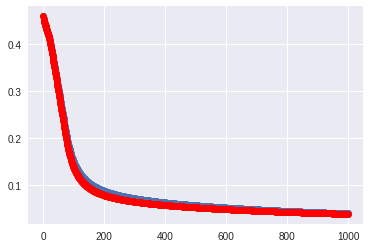

In [5]:
activation_functions = [ReLU, ReLU, ReLU, ReLU, softmax]
layers_size_vector = [784, 200, 100, 60, 30, 10]
cost_function = 'euclidean_distance'
# cost_function = 'cross-entropy'
dropout_probabilities = None
learning_rate = .003
number_of_iterations = 10000
regularization_lambda = 0
training_data_X, training_data_Y, validation_data_X, validation_data_Y, test_data_X, test_data_Y = load_data_arrays()
network = NeuralNetwork(layers_size_vector, activation_functions, cost_function, dropout_probabilities)
network.fit(training_data_X, training_data_Y, learning_rate, regularization_lambda, 1, number_of_iterations, validation_X = validation_data_X, validation_Y = validation_data_Y)
#network.fit(test_data_X, test_data_Y, learning_rate, regularization_lambda, 1, number_of_iterations)
plt.plot(network.training_costs, 'o')
plt.plot(network.validation_costs, 'ro')
plt.show()